# Land use and land cover classification with EuroSAT, Keras and TensorFlow

In this notebook we want to demonstrate the training of a CNN with the EuroSAT RGB dataset and the TensorFlow machine learning library based on the Keras API. The [EuroSAT](https://github.com/phelber/EuroSAT) dataset is based on Sentinel 2 data and consists of 10 classes.

In [ ]:
% pip install -q tf-nightly

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import time

from PIL import Image
from pathlib import Path

In [ ]:
print(tf.__version__)


2.4.0-dev20200803


In [ ]:
dataset_url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='EuroSAT.zip', extract=True)
file_path = Path(data_dir)
dir_path = file_path.parent/'2750'

In [ ]:
[x for x in dir_path.iterdir() if x.is_dir()]

[PosixPath('/root/.keras/datasets/2750/Pasture'),
 PosixPath('/root/.keras/datasets/2750/Industrial'),
 PosixPath('/root/.keras/datasets/2750/HerbaceousVegetation'),
 PosixPath('/root/.keras/datasets/2750/Forest'),
 PosixPath('/root/.keras/datasets/2750/River'),
 PosixPath('/root/.keras/datasets/2750/AnnualCrop'),
 PosixPath('/root/.keras/datasets/2750/PermanentCrop'),
 PosixPath('/root/.keras/datasets/2750/Residential'),
 PosixPath('/root/.keras/datasets/2750/SeaLake'),
 PosixPath('/root/.keras/datasets/2750/Highway')]

As in the previous notebook, we use a 75/25 training-validation split.

In [ ]:
BATCH_SIZE = 64
IMG_WIDTH, IMG_HEIGHT = 224, 224
SEED = 42
VAL_SPLIT = 0.25

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir_path,
  validation_split=VAL_SPLIT,
  subset='training',
  seed=SEED,
  batch_size=BATCH_SIZE,
  image_size=(IMG_WIDTH, IMG_HEIGHT))
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dir_path,
  validation_split=VAL_SPLIT,
  subset='validation',
  seed=SEED,
  batch_size=BATCH_SIZE,
  image_size=(IMG_WIDTH, IMG_HEIGHT))


Found 27000 files belonging to 10 classes.
Using 20250 files for training.
Found 27000 files belonging to 10 classes.
Using 6750 files for validation.


In [ ]:
class_names = np.asarray(train_ds.class_names)

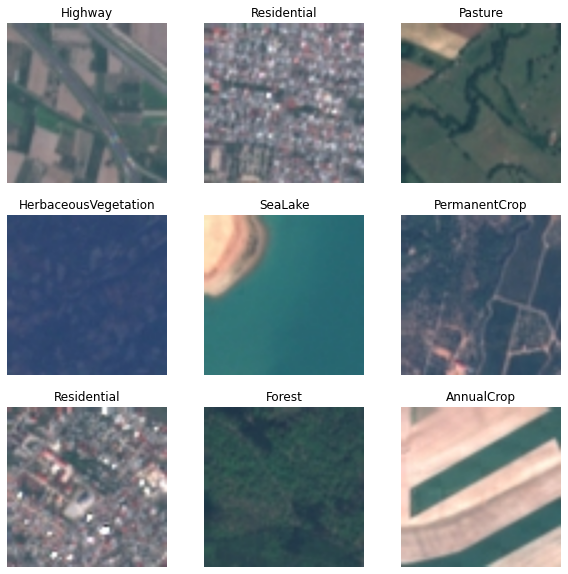

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
def format_image(image, label):
  image /= 255.0
  return image, label

train_ds = train_ds.map(format_image)
val_ds = val_ds.map(format_image)

We use a pretrained ResNet-50 model as the basis for transfer learning. The last layer is initialized randomly at the beginning, therefore it will yield a high error rate at the beginning. In the step of backpropagation those errors would be probagated back and would cause errenously large updates to the already useful weights and biases in the already pretrained model. Therefore the parameters of the pretrained model always need to be frozen and only the last layer will be trained.

In [ ]:
URL = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
model = tf.keras.Sequential([
  hub.KerasLayer(URL, input_shape=(IMG_WIDTH, IMG_HEIGHT,3), trainable=False),
  tf.keras.layers.Dense(10)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 5
history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds)

Epoch 1/5
317/317 [==============================] - 95s 299ms/step - loss: 0.0780 - accuracy: 0.9760 - val_loss: 0.1640 - val_accuracy: 0.9461
Epoch 2/5
317/317 [==============================] - 95s 299ms/step - loss: 0.0677 - accuracy: 0.9799 - val_loss: 0.1534 - val_accuracy: 0.9483
Epoch 3/5
317/317 [==============================] - 96s 303ms/step - loss: 0.0587 - accuracy: 0.9834 - val_loss: 0.1551 - val_accuracy: 0.9484
Epoch 4/5
317/317 [==============================] - 96s 302ms/step - loss: 0.0518 - accuracy: 0.9860 - val_loss: 0.1557 - val_accuracy: 0.9481
Epoch 5/5
317/317 [==============================] - 96s 303ms/step - loss: 0.0461 - accuracy: 0.9879 - val_loss: 0.1544 - val_accuracy: 0.9498


In [ ]:
t = time.time()

export_path_keras = "./{}".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1596546099
INFO:tensorflow:Assets written to: ./1596546099/assets


INFO:tensorflow:Assets written to: ./1596546099/assets


#Classification
We use the trained model to classify some unseen samples

In [ ]:
out_dir = Path('out')
im = Image.open(out_dir/'T32UQB_20190726T102031_RGB_8bit.tif')
im2arr = np.array(im) # im2arr.shape: height x width x channel
arr2im = Image.fromarray(im2arr)
im2arr.shape

(2537, 2537, 3)

In [ ]:
sample_origin_pairs = [(1000, 950),
                       (2300, 2300),
                       (900, 1090),
                       (920, 1275),
                       (1880, 1662),
                       (345, 460),
                       (35, 1400),
                       (2000, 2015)]

imgs = []
for (x, y) in sample_origin_pairs:
  sample_np = im2arr[x:x+64, y:y+64, :]
  sample_img = Image.fromarray(sample_np)
  sample_img = sample_img.resize((224,224))
  sample_np_normalized = np.array(sample_img)/255.0
  imgs.append(sample_np_normalized)
np_imgs = np.stack(imgs)
predictions = model.predict(np_imgs)

In [ ]:
predicted_ids = np.argmax(predictions, axis=-1)
probabilities = np.amax(tf.nn.softmax(predictions), axis=-1)
predicted_class_names = class_names[predicted_ids]

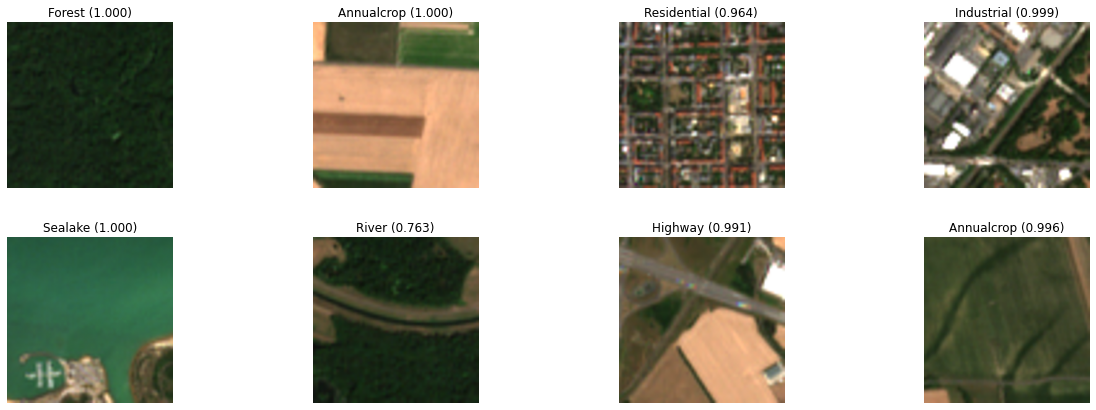

In [ ]:
plt.figure(figsize = (21, 7))
for n in range(8):
  plt.subplot(2, 4, n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(np_imgs[n])
  title = '{} ({:.3f})'.format(predicted_class_names[n].title(), probabilities[n])
  plt.title(title)
  plt.axis('off')